# Notebook Examples for Chapter 6

In [2]:
%matplotlib inline

## Training data separability

In [3]:
import ee
ee.Initialize()

# first 4 principal components of ASTER image
image = ee.Image('users/mortcanty/supervisedclassification/may0107pca') \
            .select(0,1,2,3)

# training data
table = ee.FeatureCollection('users/mortcanty/supervisedclassification/train')
trainData = image.sampleRegions(table,['CLASS_ID'])
print trainData.size().getInfo()  

7173


In [4]:
def jmsep(class1,class2,image,table):
# Jeffries-Matusita separability    
    table1 = table.filter(
        ee.Filter.eq('CLASS_ID',str(class1-1)))
    m1 = image.reduceRegion(ee.Reducer.mean(),table1)\
              .toArray() 
    s1 = image.toArray() \
         .reduceRegion(ee.Reducer.covariance(),table1)\
         .toArray()
    table2 = table.filter(
        ee.Filter.eq('CLASS_ID',str(class2-1)))
    m2 = image.reduceRegion(ee.Reducer.mean(),table2)\
              .toArray()
    s2 = image.toArray() \
        .reduceRegion(ee.Reducer.covariance(),table2,15)\
              .toArray()
    m12 = m1.subtract(m2)  
    m12 = ee.Array([m12.toList()]) # makes 2D matrix  
    s12i = s1.add(s2).divide(2).matrixInverse()
#  first term in Bhattacharyya distance
    B1 = m12.matrixMultiply(
          s12i.matrixMultiply(m12.matrixTranspose())) \
            .divide(8)
    ds1 = s1.matrixDeterminant()
    ds2 = s2.matrixDeterminant() 
    ds12 = s1.add(s2).matrixDeterminant()
#  second term
    B2 = ds12.divide(2).divide(ds1.multiply(ds2).sqrt())\
             .log().divide(2)
    B = ee.Number(B1.add(B2).project([0]).toList().get(0))
#  J-M separability
    return ee.Number(1).subtract(ee.Number(1) \
             .divide(B.exp())) \
             .multiply(2)

In [5]:
print jmsep(5,9,image,table).getInfo()

1.99715676937


In [6]:
def band_mean(current,prev):
    current = ee.String(current)
    prev = ee.Dictionary(prev)
    trainData = ee.FeatureCollection(prev.get('trainData'))
    class_id = prev.get('class_id')
    means = ee.List(prev.get('means'))
    mu = trainData.filter(ee.Filter.eq('CLASS_ID',class_id)).aggregate_mean(current)
    return ee.Dictionary({ 'trainData':trainData,'class_id':class_id,'means':means.add(mu) })

def class_mean(trainData,class_id,bandNames):
    first = ee.Dictionary({'trainData':trainData,'class_id':str(class_id),'means':ee.List([])})
    return ee.Dictionary(bandNames.iterate(band_mean,first)).get('means')

mu = ee.Array(class_mean(trainData,7,image.bandNames()))
print mu.getInfo()    

[-28.38586464084563, -13.477546924748925, 0.23433266364269972, -0.40716485753027765]


### Naive Bayes  on the GEE

In [7]:
import IPython.display as disp
jet = 'black,blue,cyan,yellow,red,brown'

# rename the class ids from strings to integers
trainData = image.sampleRegions(table,['CLASS_ID'])\
    .remap(['0','1','2','3','4','5','6','7','8','9'],
           [0,1,2,3,4,5,6,7,8,9],'CLASS_ID')
    
# train a naive Bayes classifier    
classifier = ee.Classifier.continuousNaiveBayes()
trained = classifier.\
    train(trainData,'CLASS_ID',image.bandNames())

# classify the image and display    
classified = image.classify(trained)
url = classified.select('classification').\
    getThumbURL({'min':0,'max':9,'palette':jet})
disp.Image(url=url)

### Bayes Maximum Likelihood

In [1]:
run scripts/classify -p [1,2,3,4] -a 1 imagery/AST_20070501_pca.tif imagery/train.shp

Training with MaxLike
reading training data...
training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 0.00346398353577
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 1.84680891037
thematic map written to: imagery/AST_20070501_pca_class.tif
test results written to: imagery/AST_20070501_pca_MaxLike.tst
done


In [1]:
run scripts/dispms -f imagery/AST_20070501_pca_class.tif -c \
-r  "['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']" \
-s '/home/mort/LaTeX/new projects/CRC4/Chapter6/fig6_5.eps'

<Figure size 1000x1000 with 2 Axes>

### Gaussian kernel

In [10]:
run scripts/classify -p [1,2,3,4] -a 2 -P imagery/AST_20070501_pca.tif imagery/train.shp

Training with Gausskernel
reading training data...
training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
sigma: 0.001000  error: 0.233222
sigma: 0.100000  error: 0.071905
sigma: 1.000000  error: 0.184452
sigma: 0.100000  error: 0.071905
sigma: 0.443769  error: 0.155273
sigma: 0.231308  error: 0.126928
sigma: 0.150155  error: 0.097332
sigma: 0.062185  error: 0.054189
sigma: 0.038815  error: 0.042518
sigma: 0.024371  error: 0.037099
sigma: 0.015444  error: 0.040017
sigma: 0.025348  error: 0.036682
sigma: 0.030492  error: 0.039600
sigma: 0.026173  error: 0.037307
sigma: 0.025184  error: 0.036474
sigma: 0.024962  error: 0.036474
sigma: 0.024736  error: 0.036682
sigma: 0.025073  error: 0.036474
sigma: 0.025030  error: 0.036474
sigma: 0.025004  error: 0.036474
elapsed time 71.1037061214
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row

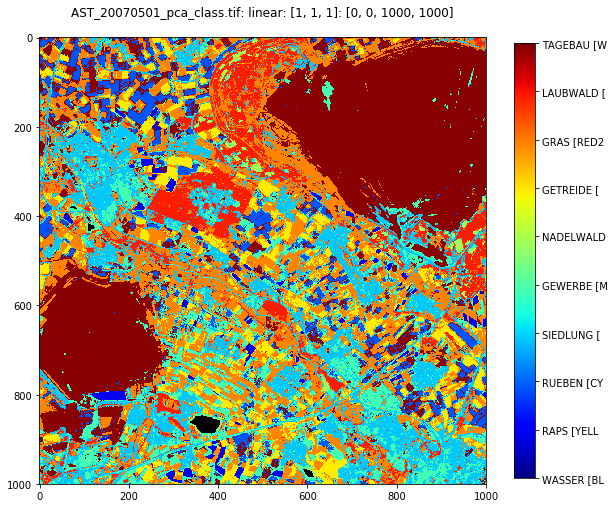

In [24]:
run scripts/dispms -f imagery/AST_20070501_pca_class.tif -c \
-r "['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']"

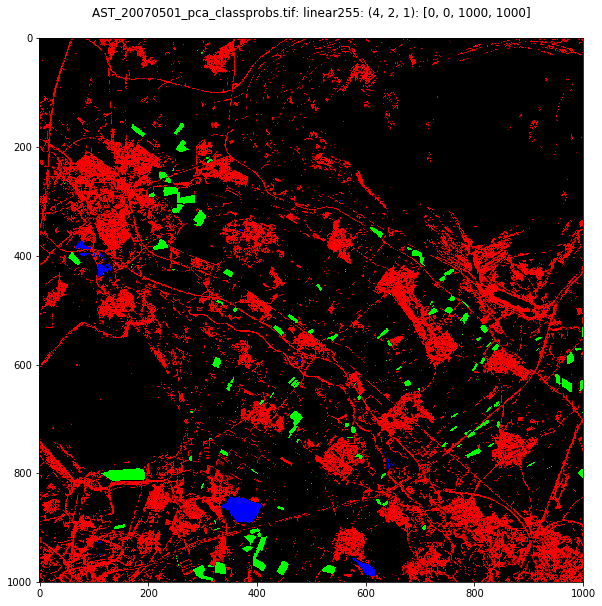

In [12]:
run scripts/dispms -f imagery/AST_20070501_pca_classprobs.tif -p [4,2,1] -e 1 \
-s '/home/mort/LaTeX/new projects/CRC4/Chapter6/fig6_6.eps'

### Ffn with backpropagation

Training with NNet(Backprop)
reading training data...
training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 129.217891932
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 0.446082115173
thematic map written to: imagery/AST_20070501_pca_class.tif


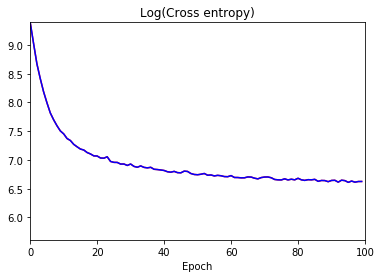

test results written to: imagery/AST_20070501_pca_NNet(Backprop).tst
done


In [39]:
run scripts/classify -p [1,2,3,4] -a 3 -e 1000 -L [10] imagery/AST_20070501_pca.tif imagery/train.shp

### Ffn with scaled conjugate gradiant

Training with NNet(Congrad)
reading training data...
training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 16.8098530769
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 0.453677892685
thematic map written to: imagery/AST_20070501_pca_class.tif


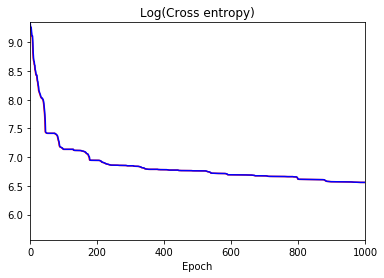

test results written to: imagery/AST_20070501_pca_NNet(Congrad).tst
done


In [38]:
run scripts/classify -p [1,2,3,4] -a 4 -e 1000 -L [10] imagery/AST_20070501_pca.tif imagery/train.shp

### Ffn in TensorFlow

#### Accessing the data

In [15]:
import auxil.readshp as rs
import gdal
import matplotlib.pyplot as plt
from osgeo.gdalconst import GA_ReadOnly
import tensorflow as tf
import numpy as np

# get the training data
infile='imagery/AST_20070501_pca.tif'
gdal.AllRegister()
inDataset = gdal.Open(infile,GA_ReadOnly)
pos=[1,2,3,4]
Xs,Ls,K,_ = rs.readshp('imagery/train.shp',inDataset,pos)
ys=np.argmax(Ls,1)
m = Ls.shape[0]

#  stretch to [-1,1]
maxx = np.max(Xs,0)
minx = np.min(Xs,0)
for j in range(len(pos)):
    Xs[:,j]=2*(Xs[:,j]-minx[j])/(maxx[j]-minx[j])-1.0

# split into train/test
idx = np.random.permutation(m)
Xs = Xs[idx,:] 
Ls = Ls[idx,:]         
ys = np.argmax(Ls,1)

Xstrn = Xs[:int(0.67*m),:]
ystrn = ys[:int(0.67*m)] 
Xstst = Xs[int(0.67*m):,:]  
ystst = ys[int(0.67*m):] 

# read entire image
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize  
Xs = np.zeros((cols*rows,4))
k= 0
for b in pos:
    band = inDataset.GetRasterBand(b)
    Xs[:,k] = band.ReadAsArray(0,0,cols,rows)\
                          .astype(float).ravel()
    k += 1      
    
#  stretch to [-1,1]
maxx = np.max(Xs,0)
minx = np.min(Xs,0)
for j in range(len(pos)):
    Xs[:,j]=2*(Xs[:,j]-minx[j])/(maxx[j]-minx[j])-1.0    

reading training data...


#### Network architecture

In [16]:
# placeholders
X = tf.placeholder(tf.float32,shape=(None,4))
y = tf.placeholder(tf.int64,shape=(None))
# network with rectified linear units (relu) 
hidden=tf.layers.dense(X,10,activation=tf.nn.relu)
logits=tf.layers.dense(hidden,10)
# cross entropy cost function
xentropy=tf.nn.sparse_softmax_cross_entropy_with_logits\
                            (labels=y,logits=logits)
cost=tf.reduce_mean(xentropy)
# training algorithm with 0.01 learning rate
optimizer=tf.train.GradientDescentOptimizer(0.01)
training_op=optimizer.minimize(cost)
# variables initializer 
init=tf.global_variables_initializer()
# accuracy evaluation
correct=tf.nn.in_top_k(logits,y,1)
accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
# saver
saver = tf.train.Saver()

#### Training and testing

In [17]:
%%time
with tf.Session() as sess:
    init.run()
    for epoch in range(20000):
        sess.run(training_op,feed_dict={X:Xstrn,y:ystrn})
    acc = accuracy.eval(feed_dict={X:Xstst,y:ystst})
    print 'Test accuracy: %f'%acc
    save_path = saver.save(sess,'imagery/dnn.ckpt')

Test accuracy: 0.928934
CPU times: user 2min 44s, sys: 4.2 s, total: 2min 48s
Wall time: 1min 32s


#### Prediction

In [18]:
with tf.Session() as sess:
    saver.restore(sess,'imagery/dnn.ckpt')
    Z = logits.eval(feed_dict={X:Xs})
    y_pred = np.argmax(Z,1)  

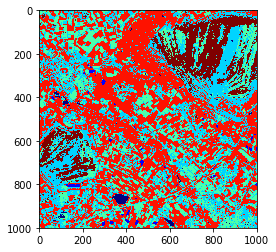

In [19]:
plt.imshow(np.reshape(y_pred/10.0,(rows,cols)),cmap='jet')

### Deep learning network

In [4]:
run scripts/classify -p [1,2,3,4] -a 6 -e 1000 -L [10,10,10] imagery/AST_20070501_pca.tif imagery/train.shp

Training with Dnn(tensorflow)
reading training data...
training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 18.7929148674
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 13.0349500179
thematic map written to: imagery/AST_20070501_pca_class.tif
test results written to: imagery/AST_20070501_pca_Dnn(tensorflow).tst
done


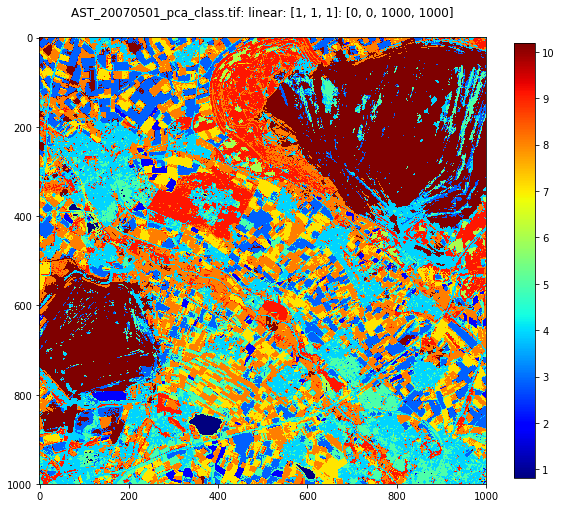

In [6]:
run scripts/dispms -f imagery/AST_20070501_pca_class.tif -c

In [7]:
run scripts/ct imagery/AST_20070501_pca_Dnn(tensorflow).tst

classification statistics
Dnn(tensorflow)test results for imagery/AST_20070501_pca.tif
Sun Jun 10 21:15:41 2018
Classification image: imagery/AST_20070501_pca_class.tif
Class probabilities image: None

Misclassification rate: 0.045262
Standard deviation: 0.004275
Conf. interval (95 percent): [0.037595 , 0.054406]
Kappa coefficient: 0.948904
Standard deviation: 0.004829
Contingency Table
[[ 161.       0.       0.       0.       0.       0.       0.       0.       0.       0.     161.       1.   ]
 [   0.     147.       0.       0.       0.       0.       2.       0.       0.       0.     149.       0.987]
 [   0.       0.     242.       0.       0.       0.       0.       0.       0.       1.     243.       0.996]
 [   0.       0.       0.     281.      22.       1.       1.       2.       0.       0.     307.       0.915]
 [   0.       0.       1.      13.     236.       0.       0.       0.       0.       0.     250.       0.944]
 [   0.       0.       0.       0.       0.     131.   

### Support Vector Machine

In [8]:
run scripts/classify -p [1,2,3,4] -a 7 imagery/AST_20070501_pca.tif imagery/train.shp

Training with SVM
reading training data...
training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 0.511019945145
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 50.2626550198
thematic map written to: imagery/AST_20070501_pca_class.tif
test results written to: imagery/AST_20070501_pca_SVM.tst
done


In [9]:
run scripts/ct imagery/AST_20070501_pca_SVM.tst

classification statistics
SVMtest results for imagery/AST_20070501_pca.tif
Sun Jun 10 21:17:50 2018
Classification image: imagery/AST_20070501_pca_class.tif
Class probabilities image: None

Misclassification rate: 0.044416
Standard deviation: 0.004237
Conf. interval (95 percent): [0.036824 , 0.053487]
Kappa coefficient: 0.949868
Standard deviation: 0.004785
Contingency Table
[[ 185.       0.       0.       0.       0.       0.       0.       0.       0.       0.     185.       1.   ]
 [   0.     160.       0.       0.       0.       0.       0.       0.       0.       0.     160.       1.   ]
 [   0.       0.     251.       0.       1.       0.       0.       0.       0.       1.     253.       0.992]
 [   0.       0.       0.     300.      21.       1.       0.       4.       1.       0.     327.       0.917]
 [   0.       0.       0.       6.     215.       0.       0.       0.       0.       0.     221.       0.973]
 [   0.       0.       0.       0.       0.     133.       0.      

In [25]:
# train a SVM  
classifier = ee.Classifier.svm(kernelType='RBF',gamma=0.01,cost=100)
trained = classifier.\
    train(trainData,'CLASS_ID',image.bandNames())

# classify the image and display    
classified = image.classify(trained)
url = classified.select('classification').\
    getThumbURL({'min':0,'max':9,'palette':jet})
disp.Image(url=url)